In [28]:
import sklearn
print(sklearn.__version__)


1.2.2


# Beginning

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import darts
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveMean, NaiveDrift
from darts.models import StatsForecastAutoARIMA, StatsForecastAutoETS, StatsForecastAutoCES, RNNModel, ExponentialSmoothing, BlockRNNModel
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tqdm import tqdm_notebook as tqdm
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mase, mse, rmse, ase, ape, r2_score, smape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Flatten
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import random
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import tensorflow as tf
from tensorflow.keras import backend as K
import os

from hyperopt import base
os.environ['PYTHONHASHSEED'] = '0'
os.environ['HYPEROPT_FMIN_SEED'] = "1"
random.seed(88)
np.random.seed(88)
tf.random.set_seed(88)
base.have_been_bugged = False  
rstate = np.random.default_rng(88)

/Users/jacobzhao/anaconda3/envs/prophet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
2024-06-02 11:04:00.611241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
df_total = pd.read_csv('time_series_thesis_question_1.csv', index_col=0)
df_total.index = pd.to_datetime(df_total.index)

In [5]:
df = TimeSeries.from_dataframe(df_total)

In [6]:
train_1, val_1 = df.split_before(pd.Timestamp('20230101'))
train_2, val_2 = df.split_before(pd.Timestamp('20230401'))
train_3, val_3 = df.split_before(pd.Timestamp('20230701'))

In [7]:
def Xy(sliding_windows):
    X = [[list(window[:-1]) for window in windows] for windows in sliding_windows]
    y = [[window[-1] for window in windows] for windows in sliding_windows]
    return np.array(X), np.array(y)

In [8]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

def spliter(df_total,
            k = 4,
            test_size = 3,
            val_size = 3):
    test = []
    val = []
    train = []
    NN_sets = {}
    window_size = k+1


    for col in df_total.columns:
        windows = [np.array(window) for window in df_total[col].rolling(window_size) if len(window) == window_size]
        test.append(windows[-(test_size):])
        val.append(windows[-(test_size+val_size):-(test_size)])
        train.append(windows[:-(test_size+val_size)])
    NN_sets['X_train'], NN_sets['y_train'] = Xy(train)
    NN_sets['X_val'], NN_sets['y_val'] = Xy(val)
    NN_sets['X_test'], NN_sets['y_test'] = Xy(test)
    return NN_sets


In [9]:
import darts
def NN_metricker(y_pred):
  y_pred_df = pd.DataFrame(y_pred.reshape((-1, 3)).transpose())
  y_pred_df.columns = df_total.columns
  y_pred_df.index = df_total.index[-3:]
  y_pred_df.index = pd.to_datetime(y_pred_df.index)
  y_pred_tf = TimeSeries.from_dataframe(y_pred_df)
  SMAPE = darts.metrics.smape(val_1, y_pred_tf)
  MASE = darts.metrics.mase(val_1, y_pred_tf, train_1)
  MAE = darts.metrics.mae(val_1, y_pred_tf)
  print(
      "Symmetric Mean absolute percentage error: {:.2f}%.".format(
          SMAPE),
          "MASE: {:.2f}".format(MASE),
          "MAE: {:.2f}".format(MAE)
      )
  return y_pred_df, SMAPE, MASE, MAE


In [10]:
df_total = pd.read_csv('time_series_thesis_question_1.csv', index_col=0)
K.clear_session()
tf.keras.backend.clear_session()
from tensorflow.keras.losses import Huber
def create_lstm_model(window, lstm_units, n_lstm_layers, optimizer_name, lr, dp, df=df_total):
    NN_sets = spliter(df, k=window)  # Assuming 'spliter' and 'df_total' are defined

    lstm_model = Sequential()
    if n_lstm_layers == 1:
        lstm_model.add(LSTM(lstm_units, return_sequences=False, input_shape=(window,1)))
    elif n_lstm_layers == 2:
        lstm_model.add(LSTM(lstm_units, return_sequences=True, input_shape=(window,1)))
        lstm_model.add(LSTM(lstm_units // 2, return_sequences=False))
    elif n_lstm_layers == 3:
        lstm_model.add(LSTM(lstm_units, return_sequences=True, input_shape=(window,1)))
        lstm_model.add(LSTM(lstm_units // 2, return_sequences=True))
        lstm_model.add(LSTM(lstm_units // 4, return_sequences=False))
    
    
    lstm_model.add(Dropout(dp))
    lstm_model.add(Dense(units=1))

    optimizer_class = {'adam': Adam, 'rmsprop': RMSprop, 'sgd': SGD, 'nadam': Nadam}[optimizer_name]
    optimizer = optimizer_class(lr)

    lstm_model.compile(optimizer=optimizer, loss=Huber())


    return lstm_model, NN_sets


In [11]:
# Hyperparameters to tune
window_values = [16, 20, 24, 28]
lstm_units_values = [16, 32, 64, 128]
n_lstm_layers_values = [1, 2, 3]
optimizer_values = ['adam', 'rmsprop', 'nadam']
lr_values = list(np.arange(1e-4, 11e-4, 1e-4))
dropout_values = list(np.arange(0, 0.5, 0.1))


# Replicate Results from LSTM

In [29]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

# Set random seeds
seed = 88
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Hyperparameters to tune
window_values = [16, 20, 24, 28]
lstm_units_values = [16, 32, 64, 128]
n_lstm_layers_values = [1, 2, 3]
optimizer_values = ['adam', 'rmsprop', 'nadam']
lr_values = list(np.arange(1e-4, 11e-4, 1e-4))
dropout_values = list(np.arange(0, 0.5, 0.1))
# Define the model creation function

trials_results = []

# Define the objective function for Hyperopt
def objective(params):
    window = int(params['window'])
    lstm_units = int(params['lstm_units'])
    n_lstm_layers = int(params['n_lstm_layers'])
    optimizer_name = params['optimizer']
    lr = params['lr']
    dropout_value = params['dropout_value']
    model, NN_sets = create_lstm_model(window, lstm_units, n_lstm_layers, optimizer_name, lr, dropout_value, df=df_total)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


    # Reshape the input data
    X_train = NN_sets['X_train'].reshape((-1, window, 1))
    y_train = NN_sets['y_train'].reshape((-1, 1))
    X_val = NN_sets['X_val'].reshape((-1, window, 1))
    y_val = NN_sets['y_val'].reshape((-1, 1))

    history = model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]
    trials_results.append({'params': params, 'val_loss': val_loss})

    return {'loss': val_loss, 'status': STATUS_OK}

# Define the hyperparameter search space
search_space = {
    'window': hp.choice('window', window_values),
    'n_lstm_layers': hp.choice('n_lstm_layers', n_lstm_layers_values),
    'lstm_units': hp.choice('lstm_units', lstm_units_values),
    'optimizer': hp.choice('optimizer', optimizer_values),
    'lr': hp.choice('lr', lr_values),
    'dropout_value': hp.choice('dropout_value', dropout_values)
}

# Conduct the Bayesian optimization
trials = Trials()
best = fmin(objective, search_space, algo=tpe.suggest, max_evals=100, trials=trials, rstate=rstate)

# Print the best hyperparameters and the corresponding validation loss
print('Best hyperparameters:')
print(best)

100%|██████████| 100/100 [4:21:29<00:00, 156.89s/trial, best loss: 0.8967740535736084] 
Best hyperparameters:
{'dropout_value': 0, 'lr': 7, 'lstm_units': 3, 'n_lstm_layers': 0, 'optimizer': 2, 'window': 1}


In [30]:
import os
import pandas as pd

# Assuming trials_results is your list of dictionaries
df = pd.DataFrame(trials_results)

# If you want to flatten the 'params' column into separate columns
df = pd.concat([df.drop(['params'], axis=1), df['params'].apply(pd.Series)], axis=1)

# Create directory if it doesn't exist
if not os.path.exists('LSTM_results'):
    os.makedirs('LSTM_results')

# Write df to a csv file in the specified directory
df.to_csv('LSTM_results/LSTM_tuning_results.csv', index=False)

In [15]:
K.clear_session()
tf.keras.backend.clear_session()
# Map the indices back to the actual values
best_window = window_values[best['window']]
best_n_lstm_layers = n_lstm_layers_values[best['n_lstm_layers']]
best_lstm_units = lstm_units_values[best['lstm_units']]
best_optimizer_name =  optimizer_values[best['optimizer']]
best_lr = lr_values[best['lr']]
best_dropout_value = dropout_values[best['dropout_value']]
print(f"Best window size: {best_window}")
print(f"Best number of LSTM layers: {best_n_lstm_layers}")
print(f"Best number of LSTM units: {best_lstm_units}")
print(f"Best optimizer: {best_optimizer_name}")
print(f"Best learning rate: {best_lr}")
print(f"Best dropout rate: {best_dropout_value}")
best_model, NN_sets = create_lstm_model(best_window, best_lstm_units, best_n_lstm_layers, best_optimizer_name, best_lr, best_dropout_value, df=df_total)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = best_model.fit(
    NN_sets['X_train'].reshape((-1, best_window, 1)),
    NN_sets['y_train'].reshape((-1, 1)),
    epochs=30,
    batch_size=16,
    validation_data=(NN_sets['X_val'].reshape((-1, best_window, 1)), NN_sets['y_val'].reshape((-1, 1))),
    callbacks=[early_stop], verbose=0
)
y_pred = best_model.predict(NN_sets['X_test'].reshape((-1, best_window, 1)))
y_pred_df, SMAPE, MASE, MAE = NN_metricker(y_pred)

Best window size: 20
Best number of LSTM layers: 1
Best number of LSTM units: 128
Best optimizer: nadam
Best learning rate: 0.0008
Best dropout rate: 0.0


In [27]:
y_pred = best_model.predict(NN_sets['X_test'].reshape((-1, best_window, 1)))
y_pred_df, SMAPE, MASE, MAE = NN_metricker(y_pred)

73/73 [==============================] - 0s 4ms/step
Symmetric Mean absolute percentage error: 14.53%. MASE: 1.14 MAE: 1.14


In [18]:
 def mimicry_generator(y_pred_df):
    z_preceding = df_total[-4:-1].reset_index()
    z_preceding.drop(z_preceding.columns[0], axis=1, inplace=True)
    z_present = df_total[-3:].reset_index()
    z_present.drop(z_present.columns[0], axis=1, inplace=True)
    z_pred = y_pred_df.reset_index()
    z_pred.drop(z_pred.columns[0], axis=1, inplace=True)
    mimic = np.square(z_present - z_pred) - np.square(z_preceding - z_pred) # large means mimickry
    return mimic, mimic.sum().sum()
mimic, mimic_index = mimicry_generator(df_total[-4:-1])
print(mimic_index)

18446.900973256765


In [26]:
import numpy as np
import pandas as pd

def mimicry_generator(y_pred_df):
    z_preceding = df_total[-4:-1].reset_index()
    z_preceding.drop(z_preceding.columns[0], axis=1, inplace=True)
    z_present = df_total[-3:].reset_index()
    z_present.drop(z_present.columns[0], axis=1, inplace=True)
    z_pred = y_pred_df.reset_index()
    z_pred.drop(z_pred.columns[0], axis=1, inplace=True)
    mimic = np.square(z_present - z_pred) - np.square(z_preceding - z_pred) # large means mimickry
    return mimic, mimic.sum().sum()

def normalize_mimicry(mimic_sum, mimic_sum_correct, mimic_sum_mimicry):
    # 非线性归一化，考虑平方关系
    normalized_mimic_sum = np.sqrt((mimic_sum - mimic_sum_correct) / (mimic_sum_mimicry - mimic_sum_correct))
    
    return normalized_mimic_sum


# 完全模仿最后一个输入值
y_pred_df_mimicry = df_total[-4:-1]
_, mimic_sum_mimicry = mimicry_generator(y_pred_df_mimicry)

# 完全正确预测
y_pred_df_correct = df_total[-3:]
_, mimic_sum_correct = mimicry_generator(y_pred_df_correct)

# 归一化函数
def mimicry_generator_normalized(y_pred_df, mimic_sum_correct, mimic_sum_mimicry):
    mimic, mimic_sum = mimicry_generator(y_pred_df)
    normalized_mimic_sum = normalize_mimicry(mimic_sum, mimic_sum_correct, mimic_sum_mimicry)
    
    return mimic, normalized_mimic_sum



mimic, normalized_mimic_sum = mimicry_generator_normalized(y_pred_df[0], mimic_sum_correct, mimic_sum_mimicry)


print("\nNormalized Mimicry Sum:")
print(normalized_mimic_sum)



Normalized Mimicry Sum:
0.8954372542032915


# significance

In [12]:
best = {'dropout_value': 0, 'lr': 7, 'lstm_units': 3, 'n_lstm_layers': 0, 'optimizer': 2, 'window': 1}

best_window = window_values[best['window']]
best_n_lstm_layers = n_lstm_layers_values[best['n_lstm_layers']]
best_lstm_units = lstm_units_values[best['lstm_units']]
best_optimizer_name =  optimizer_values[best['optimizer']]
best_lr = lr_values[best['lr']]
best_dropout_value = dropout_values[best['dropout_value']]

In [13]:
SMAPE_values = []
MASE_values = []
MAE_values = []

for i in range(20):
    best_model, NN_sets = create_lstm_model(best_window, best_lstm_units, best_n_lstm_layers, best_optimizer_name, best_lr, best_dropout_value, df=df_total)
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    history = best_model.fit(
        NN_sets['X_train'].reshape((-1, best_window, 1)),
        NN_sets['y_train'].reshape((-1, 1)),
        epochs=30,
        batch_size=16,
        validation_data=(NN_sets['X_val'].reshape((-1, best_window, 1)), NN_sets['y_val'].reshape((-1, 1))),
        callbacks=[early_stop]
    )
    y_pred = best_model.predict(NN_sets['X_test'].reshape((-1, best_window, 1)))
    y_pred_df, SMAPE, MASE, MAE = NN_metricker(y_pred)
    
    # Append the metrics to the lists
    SMAPE_values.append(SMAPE)
    MASE_values.append(MASE)
    MAE_values.append(MAE)
    K.clear_session()
    tf.keras.backend.clear_session()

73/73 [==============================] - 1s 6ms/step
Symmetric Mean absolute percentage error: 14.51%. MASE: 1.13 MAE: 1.14
Epoch 1/30
628/628 [==============================] - 10s 11ms/step - loss: 1.1246 - val_loss: 1.0595
Epoch 2/30
628/628 [==============================] - 7s 10ms/step - loss: 0.7488 - val_loss: 0.9635
Epoch 3/30
628/628 [==============================] - 7s 11ms/step - loss: 0.7231 - val_loss: 0.9836
Epoch 4/30
628/628 [==============================] - 7s 10ms/step - loss: 0.7159 - val_loss: 0.9078
Epoch 5/30
628/628 [==============================] - 7s 11ms/step - loss: 0.7107 - val_loss: 0.9209
Epoch 6/30
628/628 [==============================] - 7s 11ms/step - loss: 0.7118 - val_loss: 0.9442
Epoch 7/30
628/628 [==============================] - 7s 11ms/step - loss: 0.7085 - val_loss: 0.9107
Epoch 8/30
628/628 [==============================] - 7s 11ms/step - loss: 0.7042 - val_loss: 0.9121
Epoch 9/30
73/73 [==============================] - 1s 6ms/step
Sym

In [14]:
import os
import pickle


with open('LSTM_results/LSTM_SMAPE_values.pkl', 'wb') as f:
    pickle.dump(SMAPE_values, f)
with open('LSTM_results/LSTM_MASE_values.pkl', 'wb') as f:
    pickle.dump(MASE_values, f)
with open('LSTM_results/LSTM_MAE_values.pkl', 'wb') as f:
    pickle.dump(MAE_values, f)

In [25]:
import numpy as np
from deepsig import aso

seed = 88
np.random.seed(seed)

# Simulate scores
N = 88  # Number of random seeds

min_eps = aso(MASE_values, MASE_values_log, seed=seed)

Bootstrap iterations: 100%|█████████▉| 999/1000 [00:04<00:00, 249.02it/s]


In [35]:
from heteroskedasticity import Heteroskedasticity

In [36]:
BP = []
GQ = []
White = []
het = []
for col in df_total.columns:
    train = df_total.iloc[:-6]
    series = train[col]
    test_results = Heteroskedasticity.run_all_tests(series)
    sigl = 0.05
    bp = test_results['Breusch-Pagan'] < sigl
    gq = test_results['Goldfeld-Quandt'] < sigl
    white = test_results['White'] < sigl
    BP.append(bp)
    GQ.append(gq)
    White.append(white)
    het.append(sum([bp, gq, white]) > 2)

In [39]:
np.mean(het)

0.21373056994818654

In [26]:
min_eps

1.0

# Test window

In [ ]:
for window in list(np.arange(4, 32, 4)):
    K.clear_session()
    tf.keras.backend.clear_session()
    # Map the indices back to the actual values
    best_window = window
    best_n_lstm_layers = n_lstm_layers_values[best['n_lstm_layers']]
    best_lstm_units = lstm_units_values[best['lstm_units']]
    best_optimizer_name =  optimizer_values[best['optimizer']]
    best_lr = lr_values[best['lr']]
    best_dropout_value = dropout_values[best['dropout_value']]

    best_model, NN_sets = create_lstm_model(best_window, best_lstm_units, best_n_lstm_layers, best_optimizer_name, best_lr, best_dropout_value, df=df_total)

    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    history = best_model.fit(
        NN_sets['X_train'].reshape((-1, best_window, 1)),
        NN_sets['y_train'].reshape((-1, 1)),
        epochs=30,
        batch_size=16,
        validation_data=(NN_sets['X_val'].reshape((-1, best_window, 1)), NN_sets['y_val'].reshape((-1, 1))),
        callbacks=[early_stop], verbose=0
    )
    y_pred = best_model.predict(NN_sets['X_test'].reshape((-1, best_window, 1)))
    y_pred_df, SMAPE, MASE, MAE = NN_metricker(y_pred)

73/73 [==============================] - 0s 1ms/step
Symmetric Mean absolute percentage error: 14.64%. MASE: 1.15 MAE: 1.15
73/73 [==============================] - 1s 2ms/step
Symmetric Mean absolute percentage error: 14.40%. MASE: 1.12 MAE: 1.13
73/73 [==============================] - 1s 3ms/step
Symmetric Mean absolute percentage error: 14.36%. MASE: 1.12 MAE: 1.12
73/73 [==============================] - 1s 3ms/step
Symmetric Mean absolute percentage error: 14.31%. MASE: 1.12 MAE: 1.13
73/73 [==============================] - 1s 4ms/step
Symmetric Mean absolute percentage error: 14.45%. MASE: 1.13 MAE: 1.14
73/73 [==============================] - 1s 6ms/step
Symmetric Mean absolute percentage error: 14.44%. MASE: 1.15 MAE: 1.15
73/73 [==============================] - 1s 6ms/step
Symmetric Mean absolute percentage error: 15.67%. MASE: 1.24 MAE: 1.22


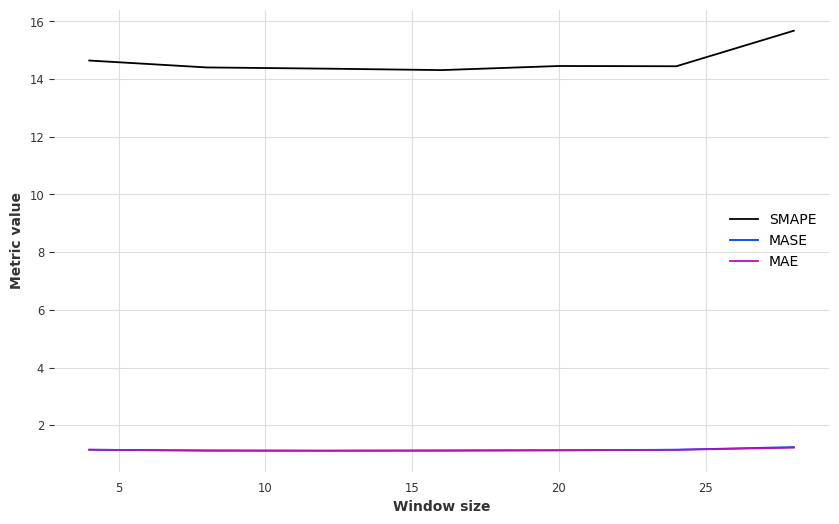

In [30]:
import matplotlib.pyplot as plt

# Initialize lists to store the metrics
SMAPE_values_w = []
MASE_values_w = []
MAE_values_w = []

# Iterate over the window sizes
for window in list(np.arange(4, 32, 4)):
    K.clear_session()
    tf.keras.backend.clear_session()
    # Map the indices back to the actual values
    best_window = window
    best_n_lstm_layers = n_lstm_layers_values[best['n_lstm_layers']]
    best_lstm_units = lstm_units_values[best['lstm_units']]
    best_optimizer_name =  optimizer_values[best['optimizer']]
    best_lr = lr_values[best['lr']]
    best_dropout_value = dropout_values[best['dropout_value']]

    best_model, NN_sets = create_lstm_model(best_window, best_lstm_units, best_n_lstm_layers, best_optimizer_name, best_lr, best_dropout_value, df=df_total)

    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    history = best_model.fit(
        NN_sets['X_train'].reshape((-1, best_window, 1)),
        NN_sets['y_train'].reshape((-1, 1)),
        epochs=30,
        batch_size=16,
        validation_data=(NN_sets['X_val'].reshape((-1, best_window, 1)), NN_sets['y_val'].reshape((-1, 1))),
        callbacks=[early_stop], verbose=0
    )
    y_pred = best_model.predict(NN_sets['X_test'].reshape((-1, best_window, 1)))
    y_pred_df, SMAPE, MASE, MAE = NN_metricker(y_pred)

    # Store the metrics
    SMAPE_values_w.append(SMAPE)
    MASE_values_w.append(MASE)
    MAE_values_w.append(MAE)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(list(np.arange(4, 32, 4)), SMAPE_values_w, label='SMAPE')
plt.plot(list(np.arange(4, 32, 4)), MASE_values_w, label='MASE')
plt.plot(list(np.arange(4, 32, 4)), MAE_values_w, label='MAE')
plt.xlabel('Window size')
plt.ylabel('Metric value')
plt.legend()
plt.show()

Mean absolute percentage error for last values: 27.03956452%. Mean absolute scaled error for last values: 1.42855095%. SMAPE for last values: 18.97706161%. MAE for last values: 1.42654481%.
Mean absolute percentage error for last values: 28.91958734%. Mean absolute scaled error for last values: 1.70333882%. SMAPE for last values: 22.58054107%. MAE for last values: 1.72166130%.
Mean absolute percentage error for last values: 32.92833095%. Mean absolute scaled error for last values: 1.91044111%. SMAPE for last values: 24.41059691%. MAE for last values: 1.91454878%.
Mean absolute percentage error for last values: 37.90876934%. Mean absolute scaled error for last values: 2.09912147%. SMAPE for last values: 26.04952890%. MAE for last values: 2.04740973%.
Mean absolute percentage error for last values: 41.03579486%. Mean absolute scaled error for last values: 2.30599313%. SMAPE for last values: 28.27194142%. MAE for last values: 2.17955421%.
Mean absolute percentage error for last values: 42

ValueError: x and y must have same first dimension, but have shapes (7,) and (9,)

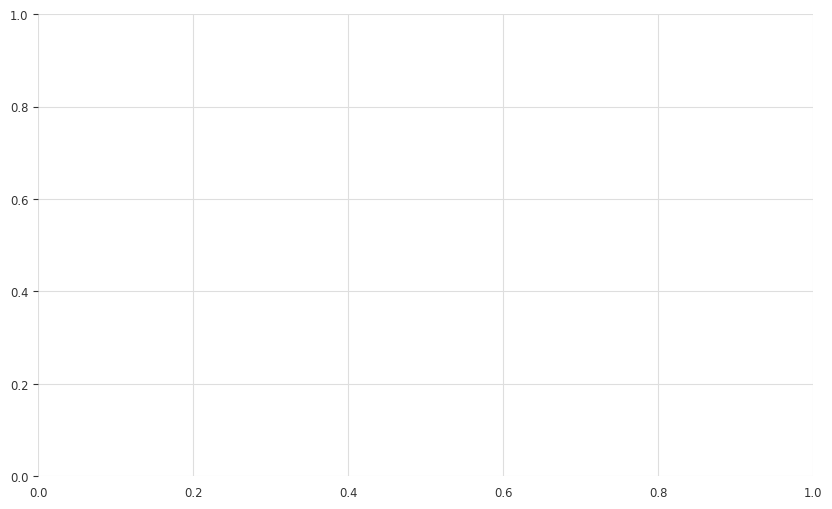

In [33]:
from darts.metrics import mape, ape, mase, rmse, mse, ase, smape, mae
def lv_model(df, train1, val1):
    last_values = df.iloc[-4:-1, :]
    last_values.index = pd.DatetimeIndex(['2023-01-01', '2023-04-01','2023-07-01'], dtype='datetime64[ns]', name='time', freq=None)
    last_values_tf = TimeSeries.from_dataframe(last_values)
    SMAPE = smape(val1, last_values_tf)
    print(
        "Mean absolute percentage error for last values: {:.8f}%.".format(
            mape(val1, last_values_tf)),
        "Mean absolute scaled error for last values: {:.8f}%.".format(
            mase(val1, last_values_tf, train1)),
        "SMAPE for last values: {:.8f}%.".format(SMAPE),
                    "MAE for last values: {:.8f}%.".format(
        mae(val_1, last_values_tf)
    )
        )
    
    return SMAPE
smape_per_lv = []
for x in list(np.arange(1, 20)):
    # Create a copy of the DataFrame
    df_train = df_total.copy()

    # Permute the last 4 rows within each column
    for col in df_train.columns:
        df_train[col].iloc[-(3 + 4 * x):-1] = np.random.permutation(df_train[col].iloc[-(3 + 4 * x):-1])
        
    SMAPE = lv_model(df_train, train_1, val_1)
    smape_per_lv.append(SMAPE)
    
plt.figure(figsize=(10, 6))
plt.plot(list(np.arange(4, 32, 4)), smape_per_lv, label='SMAPE')
plt.xlabel('Permutation size')
plt.ylabel('Metric value')
plt.legend()
plt.show()
